/var/folders/wc/c46f54kd5b5c1_d9zngpj03h0000gn/T/ipykernel_17413/738928660.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1007. 3602. 3610. ... 1105. 1349. 2366.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, col] = np.clip(df[col], df[col].quantile(0.01), df[col].quantile(0.99))


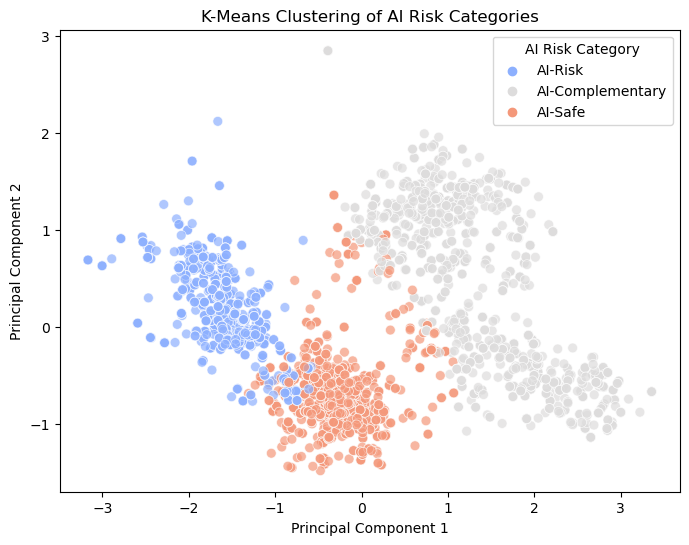

AI Risk Category
AI-Complementary    903
AI-Safe             798
AI-Risk             617
Name: count, dtype: int64


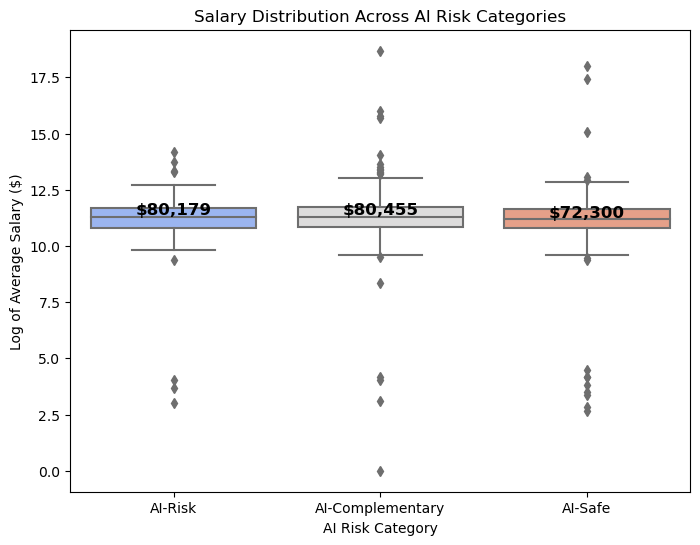

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df = pd.read_csv("cleaned_data.csv")

df["AI Impact"] = df["AI Impact"].str.replace("%", "").astype(float)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.loc[:, "AI Impact"] = df["AI Impact"].fillna(df["AI Impact"].median())
df.loc[:, "AI Workload Ratio"] = df["AI Workload Ratio"].fillna(df["AI Workload Ratio"].median())
df.loc[:, "AI Models"] = df["AI Models"].fillna(df["AI Models"].median())

# Removes extreme outliers
for col in ["AI Impact", "AI Workload Ratio", "AI Models"]:
    df.loc[:, col] = np.clip(df[col], df[col].quantile(0.01), df[col].quantile(0.99))

features = ["AI Impact", "AI Workload Ratio", "AI Models"]
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["AI Risk Cluster"] = kmeans.fit_predict(X_scaled)

cluster_means = df.groupby("AI Risk Cluster")[["AI Impact"]].mean().sort_values("AI Impact")
cluster_map = {cluster_means.index[0]: "AI-Safe",
               cluster_means.index[1]: "AI-Complementary",
               cluster_means.index[2]: "AI-Risk"}
df["AI Risk Category"] = df["AI Risk Cluster"].map(cluster_map)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df["PCA1"] = X_pca[:, 0]
df["PCA2"] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="PCA1", y="PCA2", hue="AI Risk Category", palette="coolwarm", alpha=0.7, s=50)
plt.title("K-Means Clustering of AI Risk Categories")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="AI Risk Category")
plt.show()

print(df["AI Risk Category"].value_counts())

# Salary Comparison
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="AI Risk Category", y=np.log1p(df["Average Normalized Salary"]), palette="coolwarm")
plt.xlabel("AI Risk Category")
plt.ylabel("Log of Average Salary ($)")
plt.title("Salary Distribution Across AI Risk Categories")

medians = df.groupby("AI Risk Category")["Average Normalized Salary"].median()
for i, median in enumerate(medians):
    plt.text(i, np.log1p(median) + 0.1, f"${median:,.0f}", horizontalalignment='center', fontsize=12, fontweight='bold')
plt.show()



Jobs don’t follow a simple AI vs. No-AI divide. Many roles exist in a middle ground where AI helps but doesn’t fully replace humans. There is no drastic salary differences between AI-Risk, AI-Complementary, and AI-Safe jobs as salary ranges are similar across all three clusters.
Some outliers in AI-Risk and AI-Complementary categories suggest that AI exposure alone doesn’t drive salary changes.

AI-Risk jobs are the most common, but AI is not eliminating salaries in these jobs.
The AI-Complementary category confirms that AI is not just replacing jobs but also augmenting them.
No major salary suppression due to AI exposure—other factors likely drive salary trends.

<Figure size 1200x600 with 0 Axes>

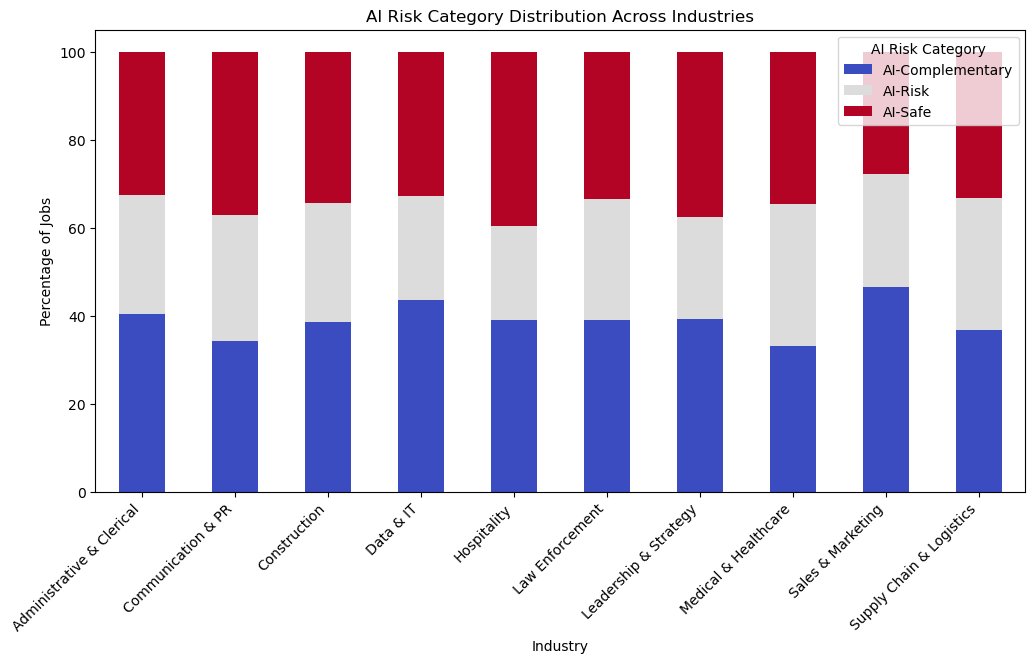

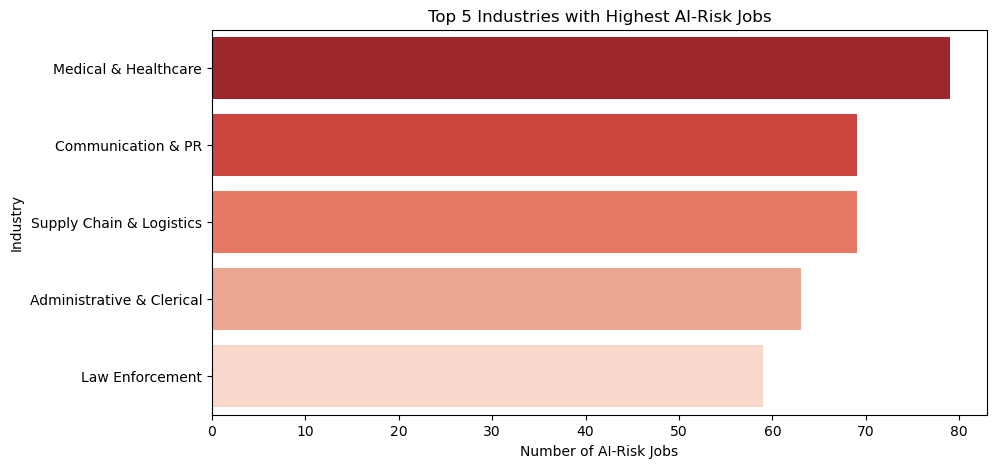

In [ ]:
industry_risk_distribution = df.groupby(["Domain", "AI Risk Category"]).size().unstack(fill_value=0)

# normalize per industry
industry_risk_percent = industry_risk_distribution.div(industry_risk_distribution.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 6))
industry_risk_percent.plot(kind="bar", stacked=True, colormap="coolwarm", figsize=(12, 6))
plt.xlabel("Industry")
plt.ylabel("Percentage of Jobs")
plt.title("AI Risk Category Distribution Across Industries")
plt.legend(title="AI Risk Category")
plt.xticks(rotation=45, ha="right")
plt.show()

top_ai_risk_industries = industry_risk_distribution["AI-Risk"].sort_values(ascending=False).head(5)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_ai_risk_industries.values, y=top_ai_risk_industries.index, palette="Reds_r")
plt.xlabel("Number of AI-Risk Jobs")
plt.ylabel("Industry")
plt.title("Top 5 Industries with Highest AI-Risk Jobs")
plt.show()


The stacked bar chart shows the percentage of jobs in each industry categorized by AI-Risk group found through clustering. Industries with a high proportion of AI-Risk jobs may be more vulnerable to automation. Industries with more AI-Complementary jobs indicate AI is enhancing work rather than replacing it. 

This chart highlights the industries with the highest number of AI-Risk jobs, rather than percentages.

Important Findings:
- AI is impacting industries differently, some are at risk, while others integrate AI as a complement to their roles.
- Healthcare, PR, Logistics, and Clerical roles are highly vulnerable to AI automation.
- Data & IT, Leadership, and Strategy roles tend to use AI as a tool rather than face job replacement.
- Automation is affecting a broader range of industries, including unexpected areas like Law Enforcement.

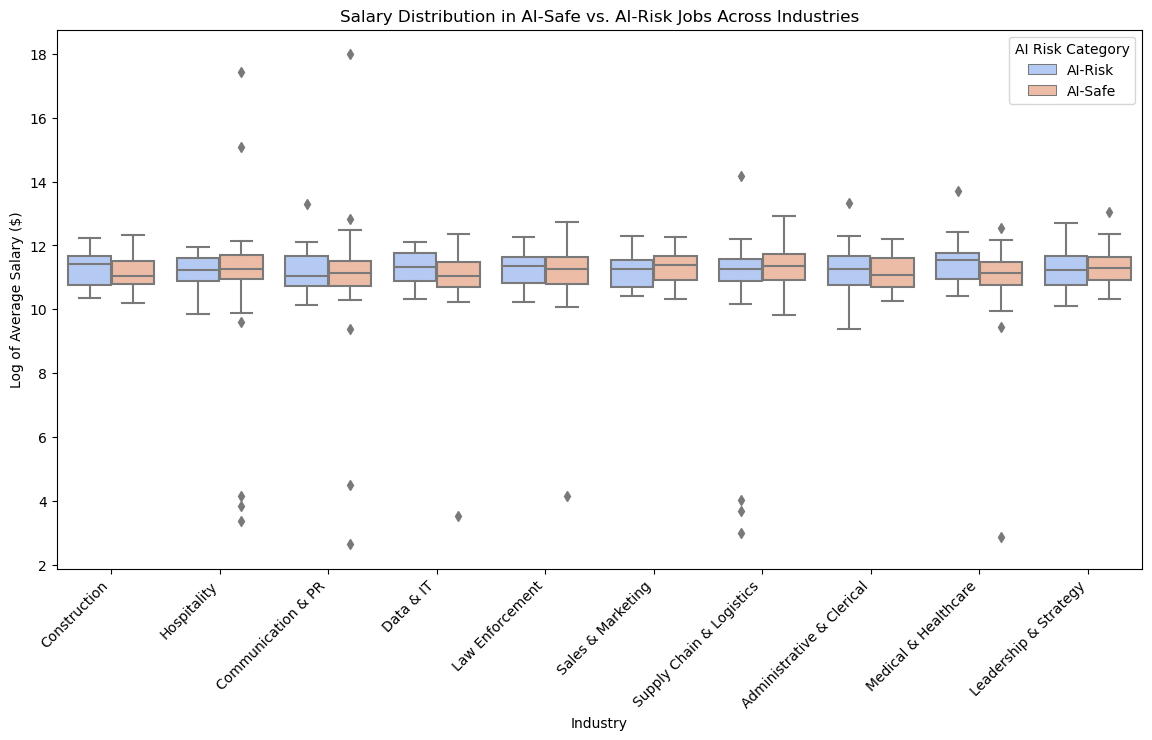

<Figure size 1400x700 with 0 Axes>

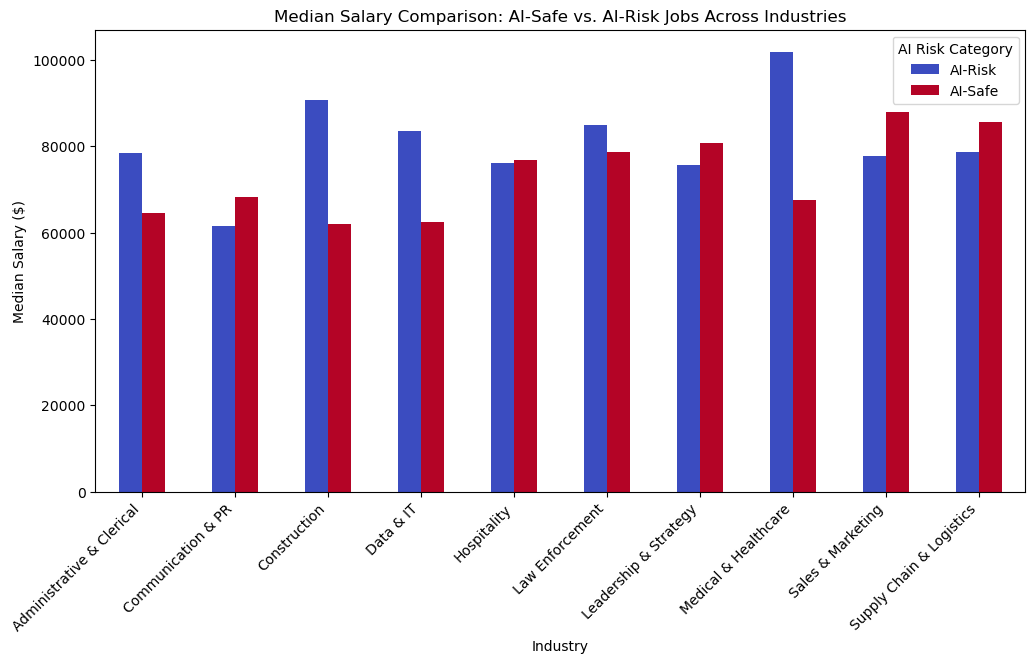

In [8]:
df_filtered = df[df["AI Risk Category"].isin(["AI-Safe", "AI-Risk"])]

plt.figure(figsize=(14, 7))
sns.boxplot(data=df_filtered, x="Domain", y=np.log1p(df_filtered["Average Normalized Salary"]), hue="AI Risk Category", palette="coolwarm")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Industry")
plt.ylabel("Log of Average Salary ($)")
plt.title("Salary Distribution in AI-Safe vs. AI-Risk Jobs Across Industries")
plt.legend(title="AI Risk Category")
plt.show()

salary_medians = df_filtered.groupby(["Domain", "AI Risk Category"])["Average Normalized Salary"].median().unstack()

plt.figure(figsize=(14, 7))
salary_medians.plot(kind="bar", colormap="coolwarm", figsize=(12, 6))
plt.xlabel("Industry")
plt.ylabel("Median Salary ($)")
plt.title("Median Salary Comparison: AI-Safe vs. AI-Risk Jobs Across Industries")
plt.xticks(rotation=45, ha="right")
plt.legend(title="AI Risk Category")
plt.show()


Salaries are relatively stable across AI-Safe and AI-Risk jobs, no major reductions in AI-exposed roles.
In some industries, high AI-Risk jobs seem to have higher salaries. This could be explained since roles that are more physical labor-focused or human-centric tend to have lower wages than roles that don't require physical labor (leadership, complex/challenging roles intellectually), and the impact of AI currently has little to do with it.
AI is not universally reducing salaries but could be reshaping earnings in specific sectors.